# 1: Load Data from OracleDB

In [1]:
import sys
import os
import pandas as pd

# Try different paths if needed
sys.path.append(os.path.abspath("../src"))

# Import the function to get the database engine
from database import get_engine

# Connect to OracleDB
engine = get_engine()

df = pd.read_sql("SELECT * FROM bank_reviews_cleaned", con=engine)
df.head()


,review,rating,review_date,app_name
0,accessible to using,5,2025-05-23,Commercial Bank of Ethiopia
1,I like it,4,2025-05-23,Commercial Bank of Ethiopia
2,why you change default network?,5,2025-05-23,Commercial Bank of Ethiopia
3,very nice 👍,5,2025-05-23,Commercial Bank of Ethiopia
4,nice fast app,5,2025-05-23,Commercial Bank of Ethiopia


# 2: Sentiment Analysis with DistilBERT

In [2]:
from sentiment import analyze_sentiments_batch

# Run sentiment analysis
df = analyze_sentiments_batch(df)
df.head()

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device set to use cpu


,review,rating,review_date,app_name,sentiment_label,sentiment_score
0,accessible to using,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999117
1,I like it,4,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999859
2,why you change default network?,5,2025-05-23,Commercial Bank of Ethiopia,NEGATIVE,0.996236
3,very nice 👍,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999858
4,nice fast app,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999833


# Bar Plot: Sentiment Label Counts

C:\Users\Admin\AppData\Local\Temp\ipykernel_6012\2759433253.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label", palette="pastel")


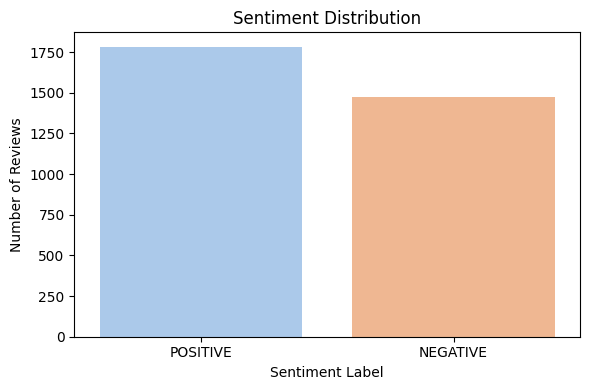

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sentiment_label", palette="pastel")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


# Heatmap: Average Sentiment Score by Bank and Rating

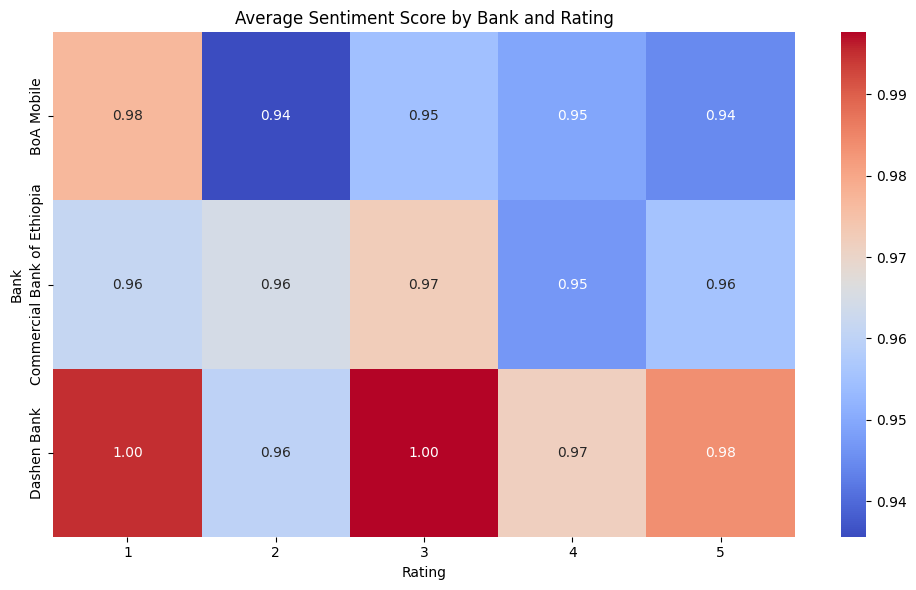

In [4]:
sentiment_pivot = df.pivot_table(
    index="app_name", 
    columns="rating", 
    values="sentiment_score", 
    aggfunc="mean"
)

plt.figure(figsize=(10,6))
sns.heatmap(sentiment_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Sentiment Score by Bank and Rating")
plt.xlabel("Rating")
plt.ylabel("Bank")
plt.tight_layout()
plt.show()


# 3: Aggregation by Bank and Rating

In [5]:
# Group by bank and star rating
agg_by_bank_rating = (
    df.groupby(["app_name", "rating"])
    .agg(
        avg_sentiment_score=("sentiment_score", "mean"),
        count=("review", "count"),
        positive_pct=("sentiment_label", lambda x: (x == "POSITIVE").mean() * 100),
        negative_pct=("sentiment_label", lambda x: (x == "NEGATIVE").mean() * 100)
    )
    .reset_index()
    .sort_values(["app_name", "rating"])
)

# Display summary
agg_by_bank_rating.head(15)

,app_name,rating,avg_sentiment_score,count,positive_pct,negative_pct
0,BoA Mobile,1,0.976995,487,8.008214,91.991786
1,BoA Mobile,2,0.935626,33,9.090909,90.909091
2,BoA Mobile,3,0.954598,78,30.769231,69.230769
3,BoA Mobile,4,0.949280,48,31.250000,68.750000
4,BoA Mobile,5,0.944687,407,67.567568,32.432432
5,Commercial Bank of Ethiopia,1,0.961459,146,15.753425,84.246575
6,Commercial Bank of Ethiopia,2,0.964495,45,20.000000,80.000000
7,Commercial Bank of Ethiopia,3,0.972303,54,11.111111,88.888889
8,Commercial Bank of Ethiopia,4,0.946951,112,45.535714,54.464286
9,Commercial Bank of Ethiopia,5,0.955466,744,72.580645,27.419355


# Visualize Sentiment Aggregation

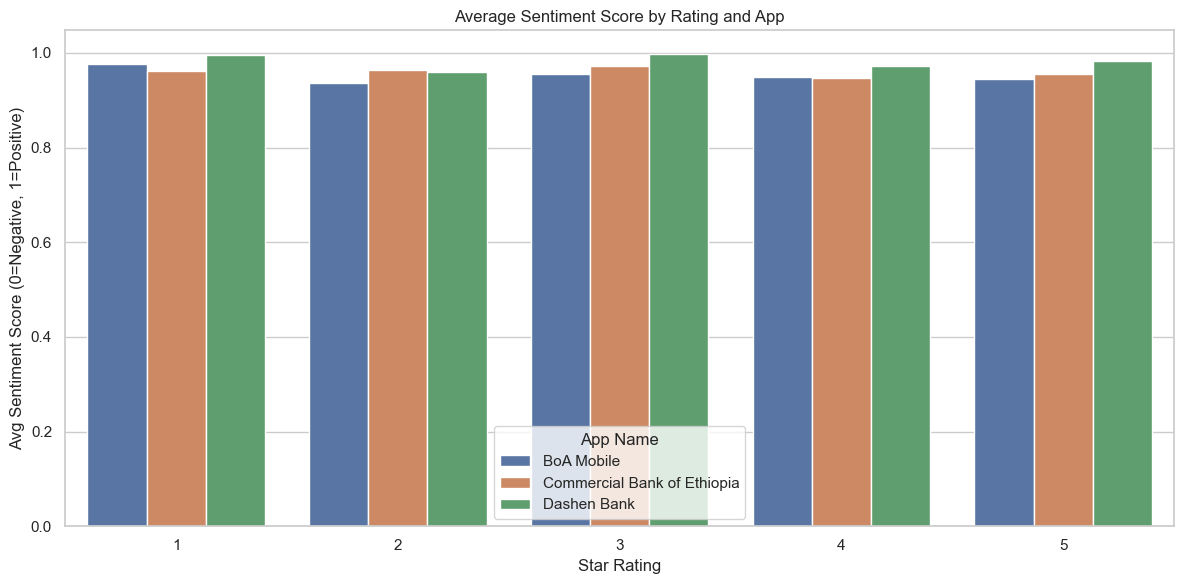

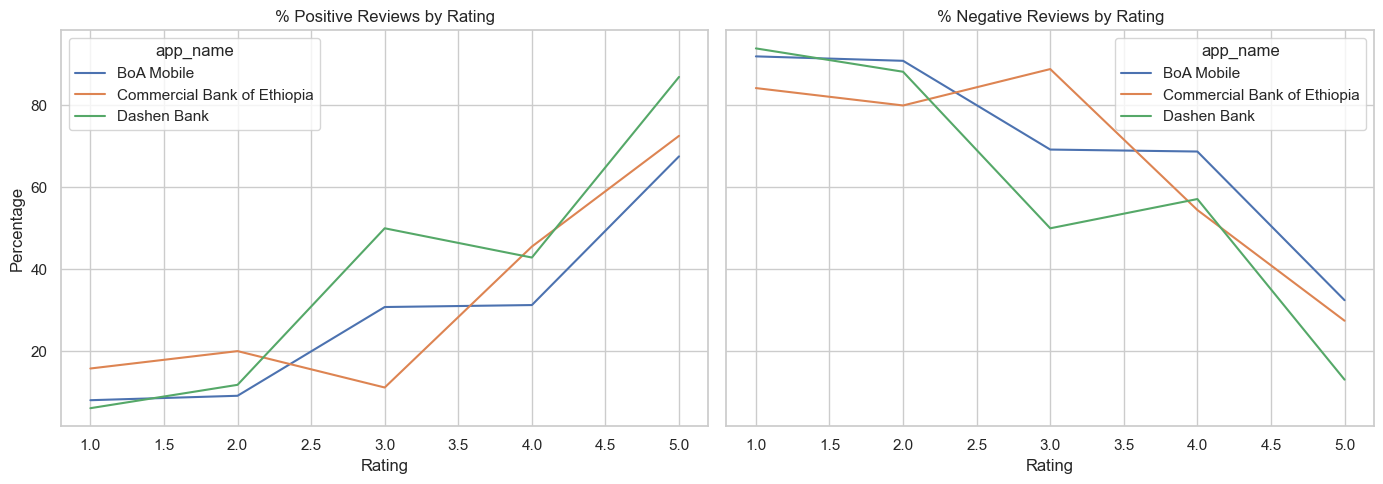

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Bar plot: Avg sentiment score by rating and app
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_by_bank_rating, x="rating", y="avg_sentiment_score", hue="app_name")
plt.title("Average Sentiment Score by Rating and App")
plt.ylabel("Avg Sentiment Score (0=Negative, 1=Positive)")
plt.xlabel("Star Rating")
plt.legend(title="App Name")
plt.tight_layout()
plt.show()

# 2. Line plot: % Positive vs % Negative per rating per app
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.lineplot(data=agg_by_bank_rating, x="rating", y="positive_pct", hue="app_name", ax=axes[0])
axes[0].set_title("% Positive Reviews by Rating")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Rating")

sns.lineplot(data=agg_by_bank_rating, x="rating", y="negative_pct", hue="app_name", ax=axes[1])
axes[1].set_title("% Negative Reviews by Rating")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Rating")

plt.tight_layout()
plt.show()


# 4: Keyword Extraction

In [7]:
from keywords import extract_keywords_tfidf

# Extract keywords
keywords_df = extract_keywords_tfidf(df, text_column="review", max_features=50, ngram_range=(1, 2))
keywords_df.head()


,keyword,score
1,app,533.127363
25,good,236.197381
4,bank,153.188197
7,best,151.345036
5,banking,115.492555


# Top Keyword Visualization (Bar Chart)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6012\2579770636.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Admin\AppData\Local\Temp\ipykernel_6012\2579770636.py:18: UserWarning: Glyph 4752 (\N{ETHIOPIC SYLLABLE NA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_6012\2579770636.py:18: UserWarning: Glyph 4813 (\N{ETHIOPIC SYLLABLE WE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Admin\OneDrive\10 Academy\Week 2\GitHub Repository\Customer Experience Analytics for Ethiopian Top 3 Banking Apps\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4752 (\N{ETHIOPIC SYLLABLE NA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\OneDrive\10 Academy\Week 2\GitHub Repository\Customer Experience Analytics for Ethiopia

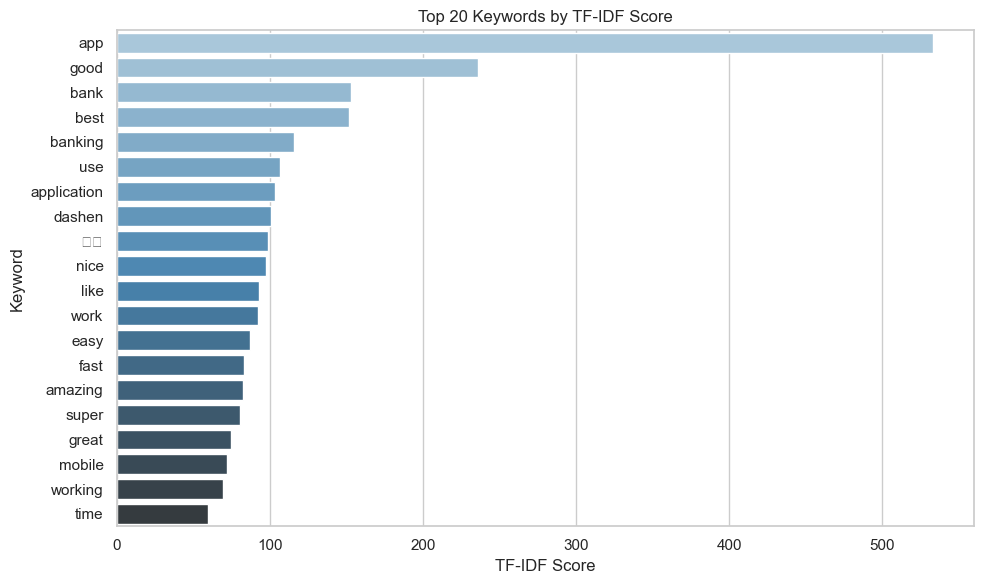

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top N keywords to visualize
TOP_N = 20
top_keywords = keywords_df.head(TOP_N)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_keywords,
    y='keyword',
    x='score',
    palette='Blues_d'
)
plt.title(f"Top {TOP_N} Keywords by TF-IDF Score")
plt.xlabel("TF-IDF Score")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


# 5: Thematic Clustering

In [9]:
from themes import assign_themes_to_keywords

# Assign themes
keywords_with_themes = assign_themes_to_keywords(keywords_df)

# Preview
keywords_with_themes.head()


,keyword,score,theme
1,app,533.127363,App Identity
25,good,236.197381,User Experience
4,bank,153.188197,Banking & Transactions
7,best,151.345036,User Experience
5,banking,115.492555,Banking & Transactions


# Visualize Theme Distribution

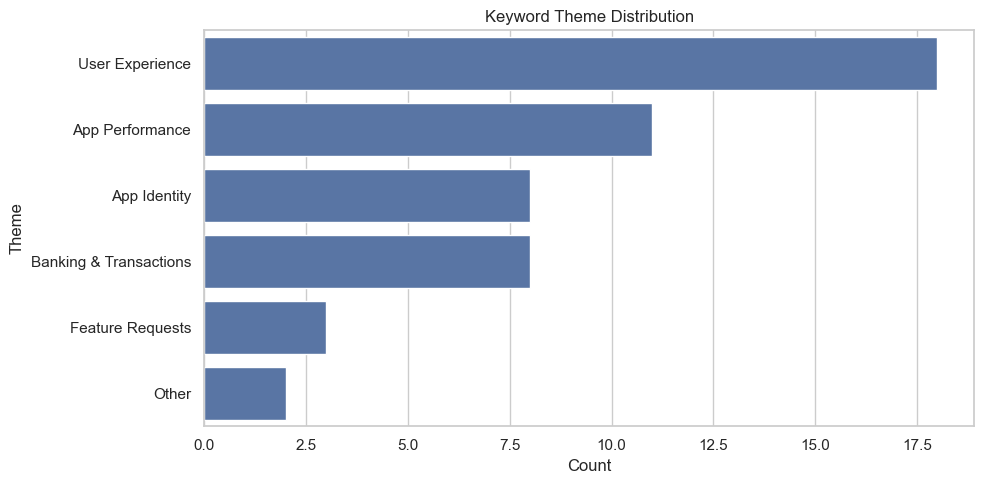

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=keywords_with_themes, y='theme', order=keywords_with_themes['theme'].value_counts().index)
plt.title("Keyword Theme Distribution")
plt.xlabel("Count")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

# 6: Save Output CSV

In [11]:
# Combine all results into df_final
df_final = df.copy()
df_final["keywords"] = keywords_df["keyword"]
df_final["themes"] = keywords_with_themes["theme"]


In [12]:
import os

# STEP 6: Save final DataFrame with selected columns
output_columns = [
    "app_name",
    "rating",
    "review",
    "sentiment_score",
    "sentiment_label",
    "keywords",
    "themes"
]

# Make sure data directory exists
os.makedirs("data", exist_ok=True)

# Save to CSV
output_path = "../data/bank_review_analysis.csv"
df_final[output_columns].to_csv(output_path, index=False)

print(f"✅ Output CSV saved to: {output_path}")



✅ Output CSV saved to: ../data/bank_review_analysis.csv
